In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-20 12:35:55.322584: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 12:35:55.360876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 12:35:55.916773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados 

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
df_Berbigao_art = pd.DataFrame(df[['Ano','Berbigao_art']])

dados = df_Berbigao_art.dropna()
anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([2020,2021,2022])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

pesca = dados['Berbigao_art'].values

In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

pesca_mean = np.mean(pesca)
pesca_std = np.std(pesca)
pesca_norm = (pesca - pesca_mean)/pesca_std

In [18]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')

history = model.fit(anos_com_dados_norm,pesca_norm, epochs=5, verbose=1)
model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Berbigao/pesos pesca art/.weights.h5', overwrite=True)

Epoch 1/5


/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step - loss: 1.0085
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9837
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9585
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9349
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9098


In [5]:
#Pegando os pesos salvos
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Berbigao/pesos pesca art/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[22.905275]
 [21.564686]
 [20.243313]]


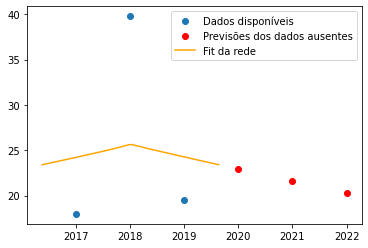

In [19]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*pesca_std + pesca_mean
prev_ausentes = model.predict(anos_para_prever_norm)*pesca_std + pesca_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,pesca,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*pesca_std + pesca_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

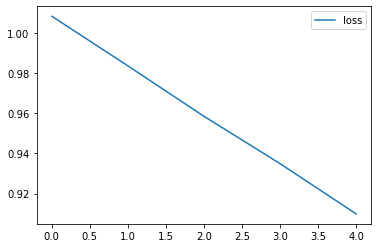

In [20]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [25]:
#Planilha com os dados preenchidos

df_previsoes = pd.DataFrame({'Ano':anos_para_prever, 'Berbigao_art':prev_ausentes.flatten()})

df_preenchido = pd.concat((dados,df_previsoes)).sort_values('Ano').reset_index(drop=True)

df_preenchido = df_preenchido.loc[3:,:]

df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Berbigao/Previsão Berbigao_art_2020-2022.xlsx')

df_preenchido

,Ano,Berbigao_art
3,2020,22.905275
4,2021,21.564686
5,2022,20.243313
